In [ ]:
import pandas as pd
import numpy as np

csv_path = "/Users/edmundtsou/Desktop/JHU Files/Sophomore/Neural Networks from Scratch/Neural-Network-from-Scratch-Mystery-Project/Data/train.csv"   # <- change
label_col = "label"

df = pd.read_csv(csv_path)
print(df.shape)
print(df.head())

X = df.drop(columns=[label_col]).values
y = df[label_col].values.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", np.unique(y))


(8000, 207)
   id       f000      f001      f002      f003      f004      f005      f006  \
0   0  -8.017551  1.524259 -0.484340 -1.131934  2.467004 -0.977590 -2.300345   
1   1   1.031026  0.788841  0.695548  1.422481 -4.263692 -1.838858 -1.033421   
2   2  14.687489  0.682977 -1.157952  0.578115 -4.063613 -0.025056 -0.504140   
3   3   1.006525 -0.210065  0.578339 -1.343567 -1.301465  1.141942  1.674118   
4   4   6.139310 -0.553952  0.863514  1.189354 -3.908431 -0.504193 -0.136285   

       f007      f008  ...      f196      f197      f198       f199      f200  \
0  0.523584 -1.386534  ... -1.083986 -0.012217  2.183332  -9.239022 -2.451272   
1 -0.618282 -2.481962  ...  0.897245 -4.632300  0.099072 -24.026205  2.108477   
2  0.650887 -0.541618  ...  0.060494 -3.274510  0.011899 -13.154913  0.755310   
3 -1.549221 -0.201150  ...  0.295386 -4.424849  0.223971 -13.104636 -1.580894   
4 -0.913505  0.150979  ...  0.166451  2.272321  0.067378   1.255918  0.521913   

        f201      f2

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_std = StandardScaler().fit_transform(X)

pca50 = PCA(n_components=min(50, X_std.shape[1]), random_state=0)
X_50 = pca50.fit_transform(X_std)

print("Explained variance (50 PCs):",
      pca50.explained_variance_ratio_.sum())



Explained variance (50 PCs): 0.4756695186927088


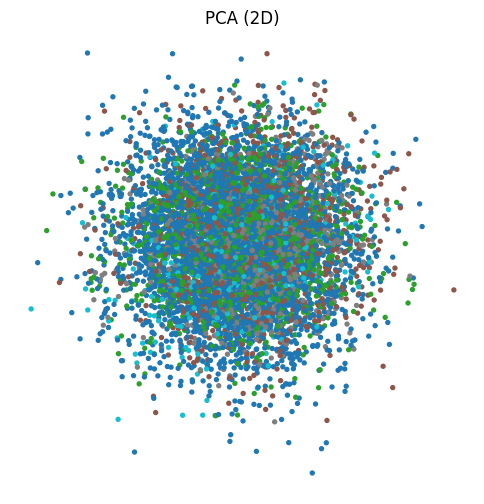

In [5]:
import matplotlib.pyplot as plt

pca2 = PCA(n_components=2, random_state=0)
Z = pca2.fit_transform(X_std)

plt.figure(figsize=(6,6))
plt.scatter(Z[:,0], Z[:,1], c=y, s=8, cmap="tab10")
plt.title("PCA (2D)")
plt.axis("off")
plt.show()


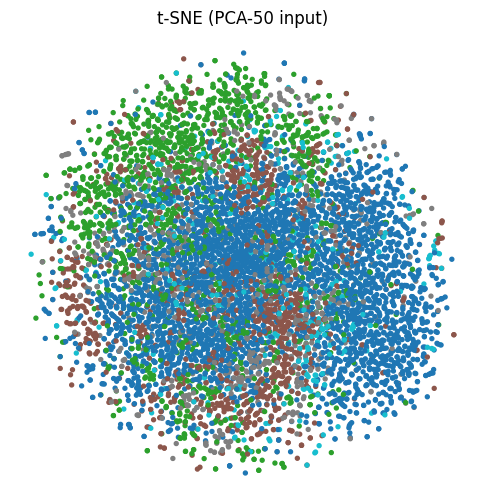

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    learning_rate="auto",
    random_state=0
)

Z = tsne.fit_transform(X_50)

plt.figure(figsize=(6,6))
plt.scatter(Z[:,0], Z[:,1], c=y, s=8, cmap="tab10")
plt.title("t-SNE (PCA-50 input)")
plt.axis("off")
plt.show()


/opt/miniconda3/envs/NNfS_final_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/NNfS_final_project/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


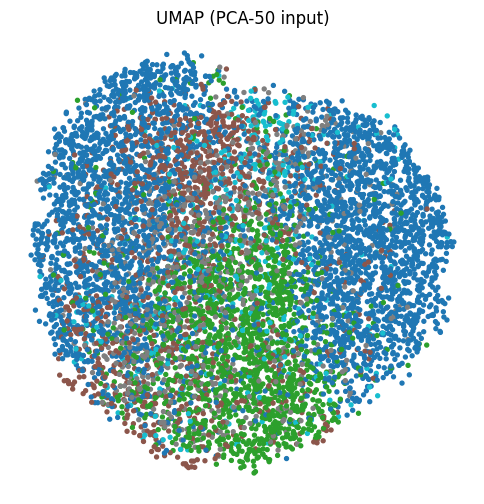

In [ ]:
import umap

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    random_state=0
)

Z = reducer.fit_transform(X_50)

plt.figure(figsize=(6,6))
plt.scatter(Z[:,0], Z[:,1], c=y, s=8, cmap="tab10")
plt.title("UMAP (PCA-50 input)")
plt.axis("off")
plt.show()


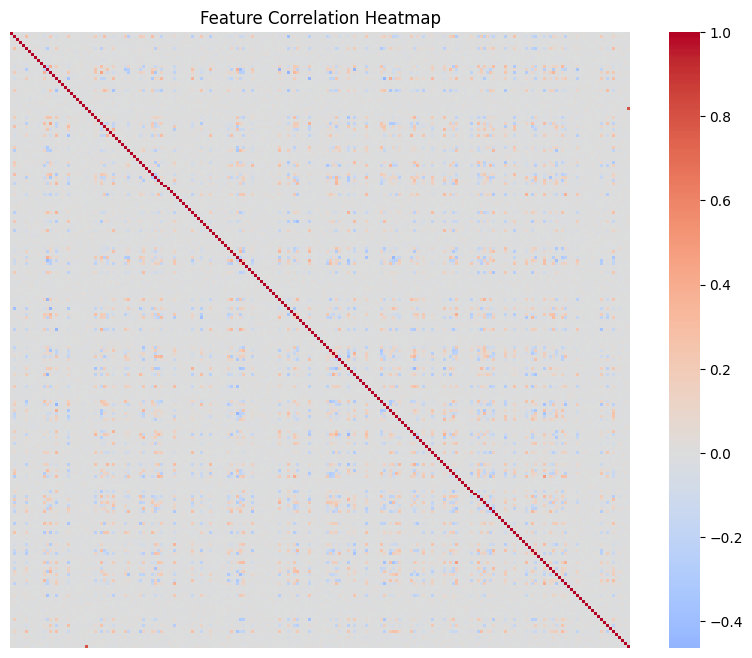

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X_df = df.drop(columns=[label_col])


corr = X_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, xticklabels=False, yticklabels=False)
plt.title("Feature Correlation Heatmap")
plt.show()


feature importance from mlp

In [ ]:
"""
- Load tabular data from CSV (features + label)
- Stratified K-fold CV
- Train MLP per fold (with class-weighted CE)
- Compute permutation importance on each fold's validation set (macro-F1)
- Average importances across folds
- Save ranked feature importances to CSV (with feature names)
"""

import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, f1_score

# Load CSV
def load_csv_data(csv_path, label_col="label", feature_cols=None, dtype=np.float32):
    df = pd.read_csv(csv_path)

    if feature_cols is None:
        feature_cols = [c for c in df.columns if c != label_col]

    X = df[feature_cols].values.astype(dtype)
    y = df[label_col].values.astype(np.int64)

    return X, y, feature_cols

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MLP(nn.Module):
    def __init__(self, in_dim, num_classes, hidden=(512, 256), dropout=0.35):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [
                nn.Linear(prev, h),
                nn.LayerNorm(h),
                nn.ReLU(),
                nn.Dropout(dropout),
            ]
            prev = h
        layers += [nn.Linear(prev, num_classes)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

@torch.no_grad()
def predict_numpy(model, X, device="cpu", batch_size=512):
    model.eval()
    preds = []
    for i in range(0, len(X), batch_size):
        xb = torch.tensor(X[i:i + batch_size], dtype=torch.float32, device=device)
        logits = model(xb)
        preds.append(torch.argmax(logits, dim=1).cpu().numpy())
    return np.concatenate(preds)


def compute_class_weights_from_labels(y_train, K, device):
    counts = np.bincount(y_train, minlength=K)
    weights = counts.sum() / (K * np.maximum(counts, 1))
    return torch.tensor(weights, dtype=torch.float32, device=device), counts


def train_mlp_on_numpy(
    X_train, y_train, X_val, y_val,
    in_dim, K,
    device="cpu",
    hidden=(512, 256),
    dropout=0.35,
    lr=1e-3,
    weight_decay=1e-4,
    epochs=40,
    patience=6,
    batch_size=128,
    num_workers=0,
):
    train_ds = TabularDataset(X_train, y_train)
    val_ds   = TabularDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=False)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=False)

    class_w, counts = compute_class_weights_from_labels(y_train, K, device=device)

    model = MLP(in_dim, K, hidden=hidden, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_macro = -1.0
    best_state = None
    bad = 0

    for ep in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss = F.cross_entropy(logits, yb, weight=class_w)

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        y_pred = []
        y_true = []
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                pred = torch.argmax(logits, dim=1).cpu().numpy()
                y_pred.append(pred)
                y_true.append(yb.numpy())

        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)

        macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

        if macro > best_macro + 1e-4:
            best_macro = macro
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_macro, counts

from sklearn.base import BaseEstimator, ClassifierMixin

class TorchPredictWrapper(BaseEstimator, ClassifierMixin):
    """
    sklearn-compatible wrapper for permutation_importance.
    Needs fit() to satisfy sklearn's estimator validation.
    """
    def __init__(self, model, device="cpu", batch_size=512):
        self.model = model
        self.device = device
        self.batch_size = batch_size

    def fit(self, X, y=None):
        # no-op: model is already trained
        return self

    def predict(self, X):
        self.model.eval()
        preds = []
        with torch.no_grad():
            for i in range(0, len(X), self.batch_size):
                xb = torch.tensor(X[i:i + self.batch_size], dtype=torch.float32, device=self.device)
                logits = self.model(xb)
                preds.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(preds)

def cv_permutation_importance_mlp_from_csv(
    csv_path,
    label_col="label",
    feature_cols=None,
    n_splits=5,
    random_state=0,
    device=None,
    # training params
    hidden=(512, 256),
    dropout=0.35,
    lr=1e-3,
    weight_decay=1e-4,
    epochs=40,
    patience=6,
    batch_size=128,
    num_workers=0,
    n_repeats=5,
):
    if device is None:
        device = "mps" if torch.backends.mps.is_available() else "cpu"

    X, y, feature_names = load_csv_data(csv_path, label_col=label_col, feature_cols=feature_cols)
    N, D = X.shape
    K = int(y.max()) + 1

    print(f"Loaded: {csv_path}")
    print("X:", X.shape, "y:", y.shape, "K:", K)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    scorer = make_scorer(f1_score, average="macro")

    fold_importances = []
    fold_importances_std = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n=== Fold {fold}/{n_splits} ===")

        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]

        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr).astype(np.float32)
        X_va_s = scaler.transform(X_va).astype(np.float32)

        model, best_macro, counts = train_mlp_on_numpy(
            X_tr_s, y_tr, X_va_s, y_va,
            in_dim=D, K=K,
            device=device,
            hidden=hidden,
            dropout=dropout,
            lr=lr,
            weight_decay=weight_decay,
            epochs=epochs,
            patience=patience,
            batch_size=batch_size,
            num_workers=num_workers,
        )

        print("Class counts (train fold):", counts)
        print(f"Best val macro-F1 during training: {best_macro:.4f}")

        # --- permutation importance on validation set ---
        wrapper = TorchPredictWrapper(model, device=device, batch_size=512)

        r = permutation_importance(
            wrapper,
            X_va_s,
            y_va,
            scoring=scorer,
            n_repeats=n_repeats,
            random_state=0,
            n_jobs=-1,
        )

        fold_importances.append(r.importances_mean)
        fold_importances_std.append(r.importances_std)

        top10 = np.argsort(r.importances_mean)[::-1][:10]
        print("Top-10 features this fold:")
        for j in top10:
            print(f"  {j:4d}  {feature_names[j]}  imp={r.importances_mean[j]:.6f}")

    imp_mean = np.mean(np.vstack(fold_importances), axis=0)
    imp_std  = np.mean(np.vstack(fold_importances_std), axis=0)

    order = np.argsort(imp_mean)[::-1]

    df_imp = pd.DataFrame({
        "rank": np.arange(1, D + 1),
        "feature_idx": order,
        "feature_name": [feature_names[i] for i in order],
        "importance_mean": imp_mean[order],
        "importance_std": imp_std[order],
    })

    out_csv = "mlp_feature_importance_perm_cv.csv"
    df_imp.to_csv(out_csv, index=False)
    print(f"\nSaved: {out_csv}")

    print("\n=== Top 20 features (CV-averaged permutation importance) ===")
    print(df_imp.head(20).to_string(index=False))

    return df_imp

if __name__ == "__main__":
    df_imp = cv_permutation_importance_mlp_from_csv(
        csv_path="Data/train.csv",
        label_col="label",
        n_splits=5,
        random_state=0,
        n_repeats=5,
        # training params (match what you used)
        hidden=(512, 256),
        dropout=0.35,
        lr=1e-3,
        weight_decay=1e-4,
        epochs=40,
        patience=6,
        batch_size=128,
        num_workers=0,
    )


Loaded: Data/train.csv
X: (8000, 206) y: (8000,) K: 5

=== Fold 1/5 ===
Class counts (train fold): [3188 1283  957  648  324]
Best val macro-F1 during training: 0.7940
Top-10 features this fold:
   127  f126  imp=0.035414
   133  f132  imp=0.031076
    38  f037  imp=0.028750
    28  f027  imp=0.028303
   188  f187  imp=0.025908
   156  f155  imp=0.023306
   180  f179  imp=0.023284
   158  f157  imp=0.022627
    11  f010  imp=0.022081
     5  f004  imp=0.021795

=== Fold 2/5 ===
Class counts (train fold): [3188 1283  957  647  325]
Best val macro-F1 during training: 0.8012
Top-10 features this fold:
   133  f132  imp=0.026925
    63  f062  imp=0.024936
   156  f155  imp=0.024554
   188  f187  imp=0.024068
   158  f157  imp=0.023967
   198  f197  imp=0.023065
   127  f126  imp=0.022716
    28  f027  imp=0.021025
   105  f104  imp=0.020789
   184  f183  imp=0.020522

=== Fold 3/5 ===
Class counts (train fold): [3188 1283  957  647  325]
Best val macro-F1 during training: 0.8187
Top-10 fea